In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import datasets, models
import torchvision
import pathlib
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import math
import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

freeze = False
dropout = True
prob = 0.3
lr = 0.001
momentum = 0.9
step_size = 20
gamma = 0.1
criterion_name = 'Focal'
optimizer_name = 'Adam'
num_classes = 2
num_epochs = 30
batch_size = 30

In [3]:
transform = v2.Compose([
    v2.Resize(256),   #must same as here
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

train_data = datasets.ImageFolder(root=f"/kaggle/input/covid19-xray-two-proposed-databases/Datasets/5-classes/Train", transform=transform)
val_data = datasets.ImageFolder(root=f"/kaggle/input/covid19-xray-two-proposed-databases/Datasets/5-classes/Val", transform=transform)
test_data = datasets.ImageFolder(root=f"/kaggle/input/covid19-xray-two-proposed-databases/Datasets/5-classes/Test", transform=transform)


train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [4]:
print('Train dataset size:', train_size)
print('Validate dataset size:', val_size)
print('Test dataset size:', test_size)
class_names = train_data.classes
print('Class names:', class_names)

Train dataset size: 2020
Validate dataset size: 500
Test dataset size: 1035
Class names: ['Bacterial', 'Covid-19', 'Lung Opacity', 'Normal', 'Viral']


labels tensor([1, 1, 0, 2, 2, 3, 3, 4, 0, 2, 1, 4])


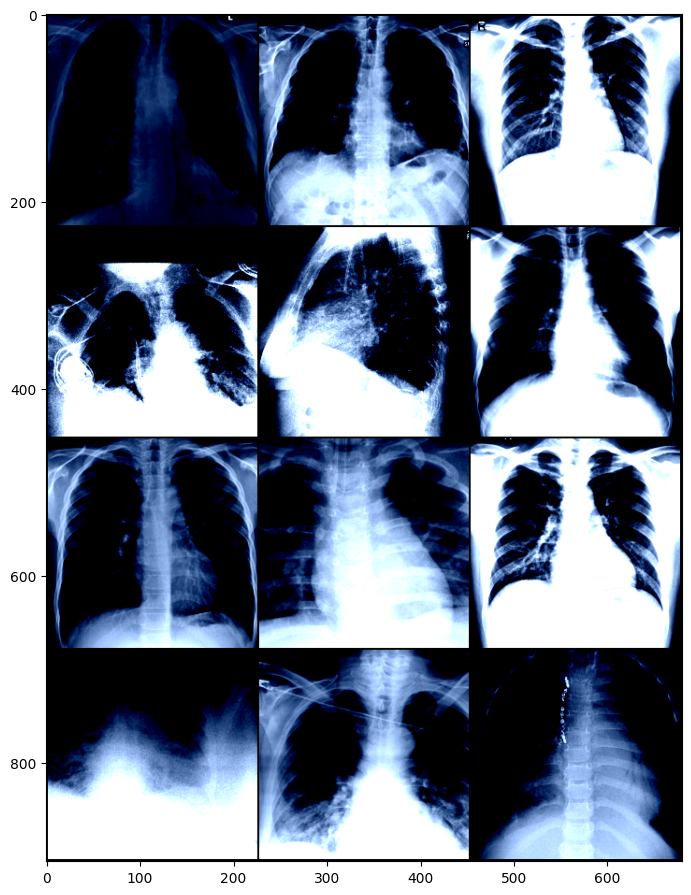

In [5]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset,batch_size = 12,shuffle=True)
    batch = next(iter(loader))
    images,labels = batch

    grid = torchvision.utils.make_grid(images,nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels',labels)

show_transformed_images(train_data)

In [6]:
model = torchvision.models.resnet18(num_classes=5, weights=None)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [8]:
train_count = len(train_data)
test_count = len(test_data)
val_count = len(val_data)
start_time = time.time()

In [9]:
start_time = time.time()
best_accuracy=0.0
train_accu_l = [0]
val_accu_l = [0]
val_loss_l = [0]
train_loss_l = [0]
batch_train_accu_l = [0]
batch_train_loss_l = [0]
for epoch in range(num_epochs):

    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    total_batches = math.ceil(train_count/batch_size)
    batch = 0
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        images_count = len(images)
        batch_train_accuracy = 0
        batch_train_loss = 0
        optimizer.zero_grad()

        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()


        batch_train_loss+= int(loss.cpu().data*images.size(0))
        _,prediction=torch.max(outputs.data,1)

        batch_train_accuracy+=int(torch.sum(prediction==labels.data))*100
        train_accuracy+=batch_train_accuracy
        train_loss+=batch_train_loss
        batch_train_accuracy = batch_train_accuracy/images_count
        batch_train_loss = batch_train_loss/images_count
        images_count+=batch_size
        batch = batch+1;
        batch_train_accu_l.append(batch_train_accuracy)
        batch_train_loss_l.append(batch_train_loss)

    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count


    model.eval()

    val_accuracy=0.0
    val_loss = 0.0
    for i, (images,labels) in enumerate(val_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        val_loss+= int(loss.cpu().data*images.size(0))
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        val_accuracy+=int(torch.sum(prediction==labels.data))*100

    val_accuracy=val_accuracy/val_count
    val_loss=val_loss/val_count
    train_accu_l.append(train_accuracy)
    val_accu_l.append(val_accuracy)
    val_loss_l.append(val_loss)
    train_loss_l.append(train_loss)

    print('Epoch: '+str(epoch+1)+' | Training Loss: '+str(round(train_loss,4))+' | Training Accuracy: '+str(round(train_accuracy,2))+"% "+' | Validation Loss: '+str(round(val_loss,4))+' | Validation Accuracy: '+str(round(val_accuracy,2))+"%")

    if val_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_5_DENSENET.model')
        best_accuracy=val_accuracy

Epoch: 1 | Training Loss: 1.348 | Training Accuracy: 41.44%  | Validation Loss: 1.466 | Validation Accuracy: 38.0%
Epoch: 2 | Training Loss: 1.1223 | Training Accuracy: 53.81%  | Validation Loss: 0.9 | Validation Accuracy: 49.6%
Epoch: 3 | Training Loss: 0.9851 | Training Accuracy: 60.05%  | Validation Loss: 1.0 | Validation Accuracy: 39.0%
Epoch: 4 | Training Loss: 0.8812 | Training Accuracy: 64.01%  | Validation Loss: 1.034 | Validation Accuracy: 45.2%
Epoch: 5 | Training Loss: 0.7911 | Training Accuracy: 67.57%  | Validation Loss: 0.634 | Validation Accuracy: 53.8%
Epoch: 6 | Training Loss: 0.7505 | Training Accuracy: 69.21%  | Validation Loss: 1.166 | Validation Accuracy: 53.8%
Epoch: 7 | Training Loss: 0.7 | Training Accuracy: 71.98%  | Validation Loss: 0.634 | Validation Accuracy: 41.0%
Epoch: 8 | Training Loss: 0.6213 | Training Accuracy: 75.35%  | Validation Loss: 1.234 | Validation Accuracy: 54.4%
Epoch: 9 | Training Loss: 0.5639 | Training Accuracy: 79.06%  | Validation Loss:

In [10]:
print(val_accu_l)
print(train_accu_l)

num_epochs = len(train_accu_l)

[0, 38.0, 49.6, 39.0, 45.2, 53.8, 53.8, 41.0, 54.4, 46.8, 52.6, 56.8, 55.0, 58.8, 55.6, 54.8, 55.4, 56.6, 56.0, 61.2, 59.0, 62.0, 59.8, 60.6, 62.8, 63.0, 55.6, 60.4, 62.2, 61.4, 62.2]
[0, 41.43564356435643, 53.81188118811881, 60.04950495049505, 64.00990099009901, 67.57425742574257, 69.20792079207921, 71.98019801980197, 75.34653465346534, 79.05940594059406, 80.04950495049505, 81.38613861386139, 82.72277227722772, 84.95049504950495, 90.34653465346534, 89.10891089108911, 90.5940594059406, 94.10891089108911, 95.64356435643565, 95.44554455445545, 97.22772277227723, 97.87128712871286, 98.21782178217822, 98.96039603960396, 99.4059405940594, 99.8019801980198, 99.05940594059406, 99.55445544554455, 99.9009900990099, 99.9009900990099, 99.35643564356435]


In [11]:
y_true = []
y_pred = []
model.eval()
test_accuracy=0.0
for i, (images,labels) in enumerate(test_loader):
    if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
    outputs=model(images)
    _,prediction=torch.max(outputs.data,1)
    test_accuracy+=int(torch.sum(prediction==labels.data))*100
    y_true.extend(labels.data.cpu().numpy())
    y_pred.extend(prediction.data.cpu().numpy())
final_test_accuracy = test_accuracy/test_count
print("Accuracy on Test Data with "+str(test_count)+" images is "+str(round(final_test_accuracy,2))+"%")

Accuracy on Test Data with 1035 images is 64.44%


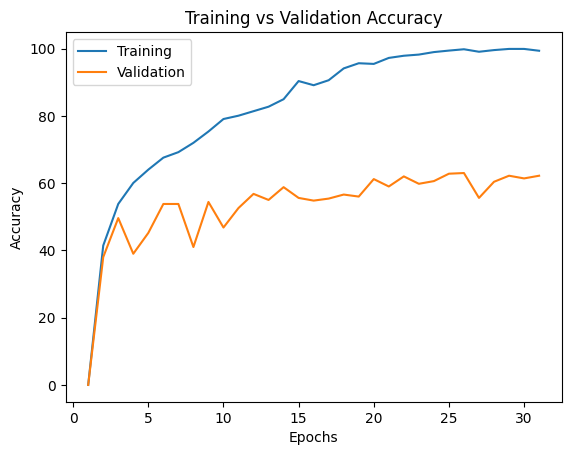

In [12]:
plt.plot(range(1, num_epochs + 1), train_accu_l, label="Training")
plt.plot(range(1, num_epochs + 1), val_accu_l, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

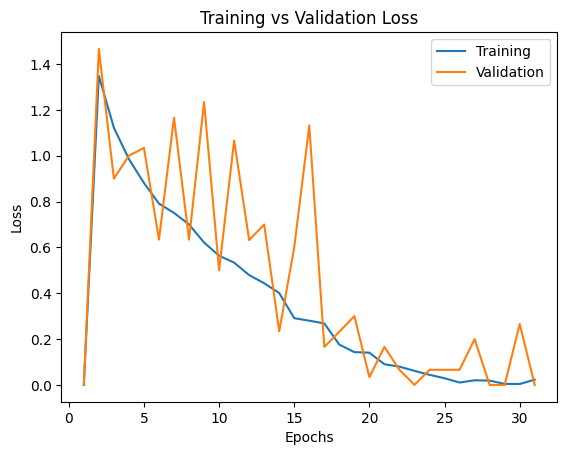

In [13]:
plt.plot(range(1,num_epochs+1),train_loss_l,label="Training")
plt.plot(range(1,num_epochs+1),val_loss_l, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

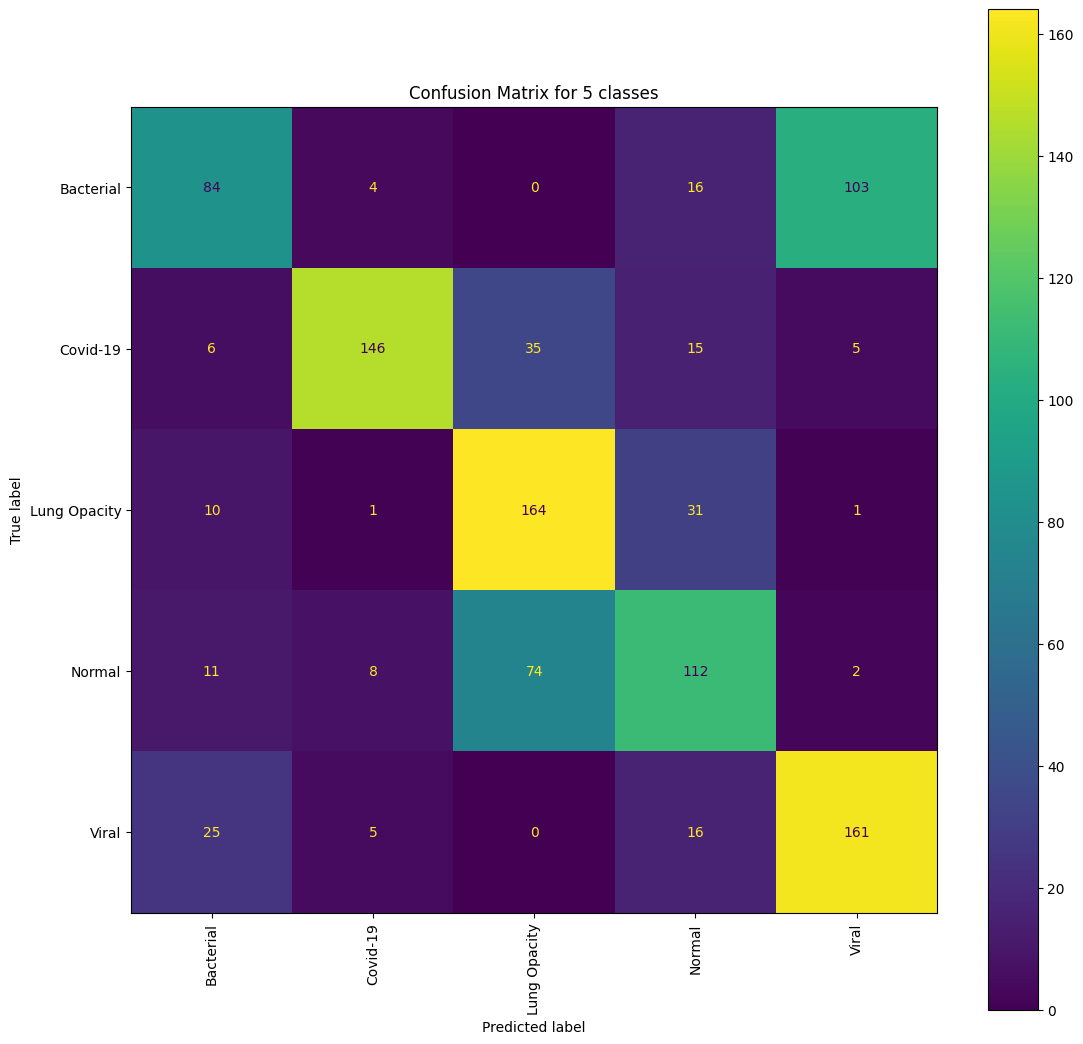

In [14]:
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=['Bacterial', 'Covid-19', 'Lung Opacity', 'Normal', 'Viral'])
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix for 5 classes")
disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()


In [15]:
print("Accuracy on Test Data :"+str(final_test_accuracy))
print("Precision on Test Data :{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall on Test Data :{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score on Test Data :{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Accuracy on Test Data :64.44444444444444
Precision on Test Data :0.64
Recall on Test Data :0.64
F1-Score on Test Data :0.64


In [16]:
import pandas
df = pandas.DataFrame(data={"Epochs": list(range(1,num_epochs+1)), "Training Accuracy": train_accu_l,"Validation Accuracy": val_accu_l})
df.to_csv("./accuracies_5_classes_ResNet.csv", sep=',',index=False)
df = pandas.DataFrame(data={"Epochs": list(range(1,num_epochs+1)), "Training Loss": train_loss_l,"Validation Loss": val_loss_l})
df.to_csv("./loss_5_classes_ResNet.csv", sep=',',index=False)
df = pandas.DataFrame(data={"Y_true": y_true, "Y_pred": y_pred})
df.to_csv("./Y_values_5_classes_ResNet.csv", sep=',',index=False)